In [1]:
%cd ..

/home/sasedov/StyleDomain/SimilarDomains


/home/sasedov/.conda/envs/StyleDomain-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import PIL

from torchvision.transforms import Resize
from itertools import combinations, product
from pathlib import Path

from core.uda_models import uda_models
from core.utils.common import mixing_noise
from core.utils.example_utils import to_im, Inferencer, vstack_with_lines, hstack_with_lines, insert_image
from core.utils.reading_weights import read_weights

from draw_util import IdentityEditor, StyleEditor, morph_g_ema, weights, set_seed

/home/sasedov/.conda/envs/StyleDomain-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# styleflow weights
!wget https://nxt.2a2i.org/index.php/s/yxdCXxSWJgAKXkP/download/styleflow_data.zip -O editing/styleflow/styleflow_data.zip
!unzip editing/styleflow/styleflow_data.zip -d editing/styleflow
!rm -rf editing/styleflow/styleflow_data.zip

--2024-02-07 17:10:34--  https://nxt.2a2i.org/index.php/s/yxdCXxSWJgAKXkP/download/styleflow_data.zip
Resolving nxt.2a2i.org (nxt.2a2i.org)... 87.242.88.169
Connecting to nxt.2a2i.org (nxt.2a2i.org)|87.242.88.169|:443... ^C
Archive:  editing/styleflow/styleflow_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of editing/styleflow/styleflow_data.zip or
        editing/styleflow/styleflow_data.zip.zip, and cannot find editing/styleflow/styleflow_data.zip.ZIP, period.


In [4]:
device = 'cuda:0'


## Setup InterFaceGAN

interfacegan_ckpts = {
    'age': torch.load('editing/interfacegan_directions/age.pt').to(device),
    'rotation': torch.load('editing/interfacegan_directions/rotation.pt').to(device),
    'smile': torch.load('editing/interfacegan_directions/smile.pt').to(device),
    'gender': torch.load('editing/interfacegan_directions/gender.pt').to(device)
}

def edit_ifgan(styles, attr, power):
    return [styles[0] + power * interfacegan_ckpts[attr]]


## Setup StyleSpace editing

style_space_config = {
    'black hair' :      [(12, 479)],
    'blond hair ':      [(12, 479), (12, 266)],
    'grey hair ' :      [(11, 286)],
    'wavy hair'  :      [(6, 500), (8, 128), (5, 92), (6, 394), (6, 323)],
    'bangs'      :      [(3, 259), (6, 285), (5, 414), (6, 128), (9, 295), (6, 322), (6, 487), (6, 504)],
    'receding hairline':[(5, 414), (6, 322), (6, 497), (6, 504)],
    'smiling'    :      [(6, 501)],
    'lipstick'   :      [(15, 45)],
    'sideburns'  :      [(12, 237)],
    'goatee'     :      [(9, 421)],
    'earrings'   :      [(8, 81)],
    'glasses'    :      [(3, 288), (2, 175), (3, 120), (2, 97)],
    'wear suit'  :      [(9, 441), (8, 292), (11, 358), (6, 223)],
    'gender'     :      [(9, 6)]
}


def edit_stylespace(styles, loc, power):
    st_idx, ch_idx = loc
    styles_tmp = [s.clone() for s in styles]
    styles_tmp[st_idx][:, ch_idx] += power
    return styles_tmp


## Setup StyleFlow Editing


from editing import StyleFlowEditor

# download weights from https://github.com/RameenAbdal/StyleFlow
# StyleFlow/flow_weight/modellarge10k.pt -> editing/modellarge10k.pt
# StyleFlow/data -> editing/styleflow_data

styleflow_model_path = 'editing/styleflow/styleflow_data/flow_weight/modellarge10k.pt'
styleflow_data_path = 'editing/styleflow/styleflow_data/data'

editor = StyleFlowEditor(styleflow_data_path, styleflow_model_path, device)

styleflow_attr_order = ['gender', 'glasses', 'yaw', 'pitch', 'baldness', 'beard', 'age', 'expression']
styleflow_attr_to_idx = dict(zip(styleflow_attr_order, range(len(styleflow_attr_order))))

Training T : 1.0
Number of trainable parameters of Point CNF: 1691649


In [5]:
# ("editing model", "special context for editing", "attribute name", "editing power")
# Only for style_space editing model context is used see `style_space_config` for details
# For attribute name pick one pair of style space positions


columns = [
    ('no_editing', None, None, None),
    ('style_space', (12, 479), 'black hair', 14), # + чернее
    ('style_space', (6, 501), 'smile', -6), # - в улыбку
    ('style_space', (15, 45), 'lipstick', -10), # - в покраску красным
    # ('if_gan', None, 'gender', 7), # + в улыбку
    ('if_gan', None, 'rotation', -5), # - направо
    ('if_gan', None, 'age', -3), # + выше
    ('styleflow', None, 'gender', 0.0)
]

In [6]:
rows = [
    ('original', None),
    ('sketch', 'td'),
    ('pixar', 'td'),
    ('anime', 'td'),
    ('joker', 'td'),
    ('zombie', 'td'),
    ('anastasia', 'im2im'),
    ('mermaid', 'im2im')
]

In [14]:
## Setup latents (from styleflow) and inference parameters

truncation = 0.8
offset_power = 0.7
linear_size = 128


editor._allocate_entity(6)
w_original = [torch.from_numpy(editor.w_current_np[:, 0, :]).to(device).float()]
w_original = [w_original[0].unsqueeze(1).repeat(1, 18, 1)]

In [15]:
image = []

for row_domain, da_type in rows:
    
    row_image = []
    for edit_type, ctx, attr_name, power in columns:        
        if row_domain == 'original':
            ckpt = read_weights(weights[rows[1][0]])
        else:
            ckpt = read_weights(weights[row_domain])
        
        model = Inferencer(ckpt, device)
        
        if 'style_latents' in ckpt and row_domain != 'original':
            w_current = w_original[0].clone()
            w_current[:, 7:, :] = ckpt['style_latents'].to(device)
            w = [w_current]
        else:
            w = w_original
        
        if row_domain == 'original':
            if edit_type == 'style_space':
                s_code = model.sg2_source.get_s_code(w, inputz_is_latent=True, truncation=truncation)
                s_code_edited_attr = edit_stylespace(s_code, ctx, power)
                trg_im, _ = model.sg2_source(s_code_edited_attr, is_s_code=True)

            elif edit_type == 'if_gan':
                w_edited = edit_ifgan(w, attr_name, power)
                trg_im, _ = model(
                    w_edited, input_is_latent=True, 
                    truncation=truncation, 
                    offset_power=offset_power
                )
            elif edit_type == 'styleflow':
                _, w_edited = editor.get_edited_pair(styleflow_attr_to_idx[attr_name], power)
                trg_im, _ = model([w_edited], input_is_latent=True, truncation=truncation, offset_power=offset_power)
            else:
                trg_im, _ = model(
                    w, input_is_latent=True, 
                    truncation=truncation, 
                    offset_power=offset_power
                )
        else:
            if edit_type == 'style_space':
                s_code = model.sg2_source.get_s_code(w, input_is_latent=True, truncation=truncation)
                domain_editor = StyleEditor(ckpt, device)

                s_code_da_edited = domain_editor(s_code, offset_power)
                s_code_edited_attr = edit_stylespace(s_code_da_edited, ctx, power)
                trg_im, _ = model.sg2_source(s_code_edited_attr, is_s_code=True)

            elif edit_type == 'if_gan':
                w_edited = edit_ifgan(w, attr_name, power)
                _, trg_im = model(
                    w_edited, input_is_latent=True, 
                    truncation=truncation, 
                    offset_power=offset_power
                )
            elif edit_type == 'styleflow':
                _, w_edited = editor.get_edited_pair(styleflow_attr_to_idx[attr_name], power)
                _, trg_im = model([w_edited], input_is_latent=True, truncation=truncation, offset_power=offset_power)
            else:
                _, trg_im = model(
                    w, input_is_latent=True, 
                    truncation=truncation, 
                    offset_power=offset_power
                )
        
        row_image.append(Resize(linear_size)(to_im(trg_im, nrow=2)))
    
    if da_type == 'im2im':
        pil_image = PIL.Image.open(f'image_domains/{row_domain}.png') 
        pil_image = pil_image.resize((linear_size - 16, linear_size - 16))
        additional_image = insert_image(np.array(pil_image), 128)
        
    else:
        additional_image = np.ones((linear_size, linear_size, 3), dtype=np.uint8) * 255
    
    image.append([additional_image] + row_image)

## Draw Results

In [16]:
skip_width = 10
skip_vertical = 15

row_h, row_w = hstack_with_lines(image[0], skip_width).shape[:2]

final_image = [np.ones((row_h, row_w, 3), dtype=np.uint8) * 255]

for row_stack in image:
    final_image.append(hstack_with_lines(row_stack, skip_width))
    
final_image = vstack_with_lines(final_image, skip_vertical)

In [17]:
abb_to_cap = {
    'original': 'Original', 'pixar': 'Pixar', 'sketch': 'Sketch', 'joker': 'The Joker', 
    'zombie': 'Zombie', 'anime': 'Anime', 'botero': 'Botero', 'pop_art': 'Pop Art',
    'black hair': 'Black\nHair', 'smile': 'Smile', 'lipstick': 'Lipstick', 'rotation':  'Rotation', 
    'age': 'Age', 'gender': 'Gender',
    None: ''
}

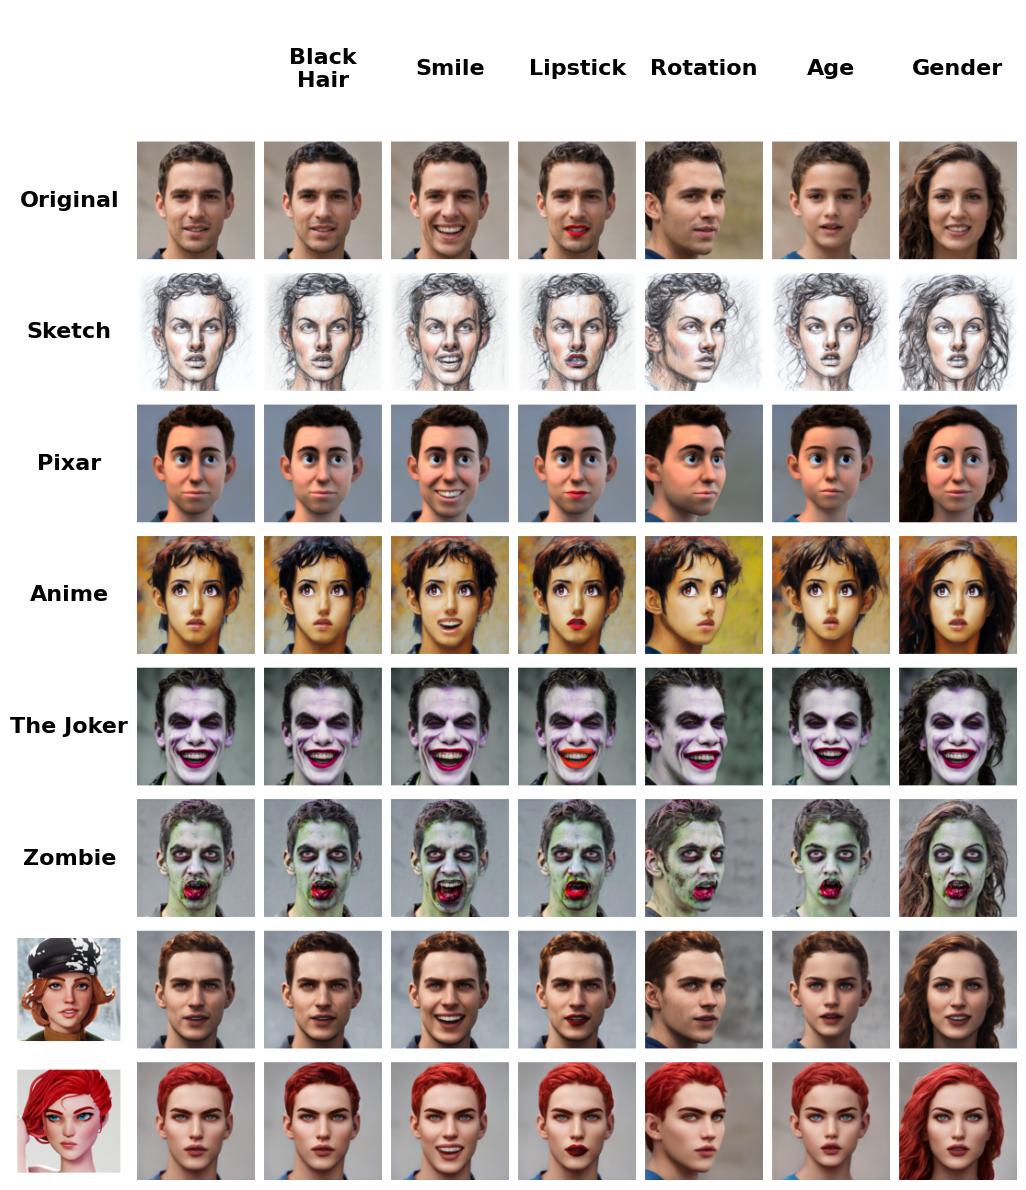

In [18]:
%matplotlib inline

num = 3

plt.figure(figsize=(num * len(columns), num * len(rows) // 2))
plt.imshow(final_image)
plt.axis('off')

for i, (_, _, attr, _) in enumerate(columns):
    plt.text(linear_size // 2 + (linear_size + skip_width) * (i + 1), linear_size // 2, 
             abb_to_cap[attr], fontsize=16, weight='bold',
             horizontalalignment='center', verticalalignment='center')


for i, (domain, da_type) in enumerate(rows):
    if da_type == 'im2im':
        continue
    plt.text(linear_size // 2, linear_size * 3 // 2 + skip_vertical + (linear_size + skip_vertical) * i, 
             abb_to_cap[domain], fontsize=16, weight='bold', 
             horizontalalignment='center', verticalalignment='center')

    
plt.tight_layout()
plt.show()